In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image

torch.cuda.empty_cache()

In [2]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

########## Mean and std are calculated from the train dataset
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    # random brightness and random contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [3]:
'''Load LUNA dataset'''

# import h5py 
# import numpy as np
# import skimage
# import torch
# from torch.utils.data import DataLoader
# from torch.utils.data import TensorDataset
# f = h5py.File('all_patches.hdf5','r')
# f.keys()
# img = f['ct_slices'][:]  
# label = f['slice_class'][:] 
# f.close()
# print(np.shape(img))
# print('b',np.shape(label))
# skimage.io.imshow(img[120])
# print(label[120])
# batchsize=4

# class LungDataset(Dataset):
#     def __init__(self, img, label, transform=None):
#         self.img = img
#         self.label = label
#         self.transform = transform

#     def __len__(self):
#         return len(self.img)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        
#         image = PIL_image = Image.fromarray(self.img[idx]).convert('RGB')

#         if self.transform:
#             image = self.transform(image)
#         sample = {'img': image,
#                   'label': int(self.label[idx])}
#         return sample
    
# trainset = LungDataset(img, label, transform= val_transformer)
# valset = LungDataset(img, label, transform= val_transformer)
# train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
# val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
# modelname = 'medical_transfer'

'Load LUNA dataset'

In [4]:
batchsize=4
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample



    
if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='/home/wangchenxu/covid/Images-processed',
                                   txt_COVID='/home/wangchenxu/covid/Data-split/COVID/trainCT_COVID.txt',
                                   txt_NonCOVID='/home/wangchenxu/covid/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                                   transform=train_transformer)
    valset = CovidCTDataset(root_dir='/home/wangchenxu/covid/Images-processed',
                                 txt_COVID='/home/wangchenxu/covid/Data-split/COVID/valCT_COVID.txt',
                                 txt_NonCOVID='/home/wangchenxu/covid/Data-split/NonCOVID/valCT_NonCOVID.txt',
                                 transform=val_transformer)
    testset = CovidCTDataset(root_dir='/home/wangchenxu/covid/Images-processed',
                                 txt_COVID='/home/wangchenxu/covid/Data-split/COVID/testCT_COVID.txt',
                                 txt_NonCOVID='/home/wangchenxu/covid/Data-split/NonCOVID/testCT_NonCOVID.txt',
                                 transform=val_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)
    

425
118
203


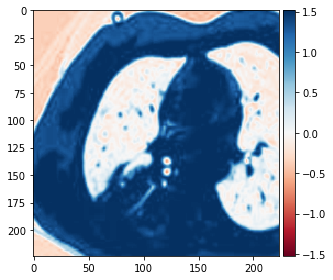

In [5]:
for batch_index, batch_samples in enumerate(train_loader):      
        data, target = batch_samples['img'], batch_samples['label']
skimage.io.imshow(data[0,1,:,:].numpy())

In [6]:
#training process is defined here 

alpha = None
## alpha is None if mixup is not used
alpha_name = f'{alpha}'
device = 'cuda'

def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        
        ## adjust data to meet the input dimension of model
#         data = data[:, 0, :, :]
#         data = data[:, None, :, :]    
        
        #mixup
#         data, targets_a, targets_b, lam = mixup_data(data, target, alpha, use_cuda=True)
        
        
        optimizer.zero_grad()
        output = model(data)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
        
        #mixup loss
#         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)

        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    
#     print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f = open('model_result/{}.txt'.format(modelname), 'a+')
#     f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f.write('\n')
#     f.close()

In [7]:
#val process is defined here

def val(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [8]:
#test process is defined here 

def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
#             print(target)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)
            
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [9]:
### Dense169
import torchvision.models as models
model = models.densenet169(pretrained=True).cuda()
# # modelname = 'Dense169'

"""load MoCo pretrained model"""
checkpoint = torch.load('save_model_dense/checkpoint_luna_covid.tar')
# # # print(checkpoint.keys())
# # # print(checkpoint['arch'])

state_dict = checkpoint['state_dict']
for key in list(state_dict.keys()):
    if 'module.encoder_q' in key:
#         print(key[17:])
        new_key = key[17:]
        state_dict[new_key] = state_dict[key]
    del state_dict[key]
for key in list(state_dict.keys()):
    if  key == 'classifier.0.weight':
        new_key = 'classifier.weight'
        state_dict[new_key] = state_dict[key]
        del state_dict[key]
    if  key == 'classifier.0.bias':
        new_key = 'classifier.bias'
        state_dict[new_key] = state_dict[key]
        del state_dict[key]
    if  key == 'classifier.2.weight' or key == 'classifier.2.bias':
        del state_dict[key]
state_dict['classifier.weight'] = state_dict['classifier.weight'][:1000,:]
state_dict['classifier.bias'] = state_dict['classifier.bias'][:1000]
model.load_state_dict(checkpoint['state_dict'])

# # # print(model)

<All keys matched successfully>

In [10]:
"""Load Self-Trans model"""
"""Change names and locations to the Self-Trans.pt"""


# model = models.densenet169(pretrained=True).cuda()
# # pretrained_net = torch.load('model_backup/Dense169.pt')
# # pretrained_net = torch.load('model_backup/mixup/Dense169_0.6.pt')
# pretrained_net = torch.load('save_model_dense/Dense169_ssl_luna_moco_None_covid_moco_covid.pt')


# model.load_state_dict(pretrained_net)

# modelname = 'Dense169_ssl_luna_moco'

'Change names and locations to the Self-Trans.pt'

In [13]:
# train
bs =batchsize
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, weight_decay=1e-3)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
total_epoch = 150
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epoch)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
# scheduler = StepLR(optimizer, step_size=1)

for epoch in range(1, total_epoch+1):
    
    scheduler.step() 
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        
           
        
#         if epoch == total_epoch:
        torch.save(model.state_dict(), "save_model_dense/moco_covid.pt")  
        
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

#         f = open('model_result/medical_transfer/{}_{}.txt'.format(modelname,alpha_name), 'a+')
#         f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
#         epoch, r, p, F1, acc, AUC))
#         f.close()



Train Epoch: 1 [0/107 (0%)]	Train Loss: 0.002301
Train Epoch: 1 [4/107 (4%)]	Train Loss: 0.000091
Train Epoch: 1 [8/107 (7%)]	Train Loss: 0.000197
Train Epoch: 1 [12/107 (11%)]	Train Loss: 0.000003
Train Epoch: 1 [16/107 (15%)]	Train Loss: 0.000295
Train Epoch: 1 [20/107 (19%)]	Train Loss: 0.000030
Train Epoch: 1 [24/107 (22%)]	Train Loss: 0.000005
Train Epoch: 1 [28/107 (26%)]	Train Loss: 0.000300
Train Epoch: 1 [32/107 (30%)]	Train Loss: 0.000442
Train Epoch: 1 [36/107 (34%)]	Train Loss: 0.000007
Train Epoch: 1 [40/107 (37%)]	Train Loss: 0.000021
Train Epoch: 1 [44/107 (41%)]	Train Loss: 0.000052
Train Epoch: 1 [48/107 (45%)]	Train Loss: 0.000014
Train Epoch: 1 [52/107 (49%)]	Train Loss: 0.000007
Train Epoch: 1 [56/107 (52%)]	Train Loss: 0.000462
Train Epoch: 1 [60/107 (56%)]	Train Loss: 0.000034
Train Epoch: 1 [64/107 (60%)]	Train Loss: 0.000019
Train Epoch: 1 [68/107 (64%)]	Train Loss: 0.000185
Train Epoch: 1 [72/107 (67%)]	Train Loss: 0.000013
Train Epoch: 1 [76/107 (71%)]	Train L

Train Epoch: 3 [32/107 (30%)]	Train Loss: 0.000018
Train Epoch: 3 [36/107 (34%)]	Train Loss: 0.000026
Train Epoch: 3 [40/107 (37%)]	Train Loss: 0.000015
Train Epoch: 3 [44/107 (41%)]	Train Loss: 0.000029
Train Epoch: 3 [48/107 (45%)]	Train Loss: 0.000266
Train Epoch: 3 [52/107 (49%)]	Train Loss: 0.000222
Train Epoch: 3 [56/107 (52%)]	Train Loss: 0.000118
Train Epoch: 3 [60/107 (56%)]	Train Loss: 0.000028
Train Epoch: 3 [64/107 (60%)]	Train Loss: 0.000024
Train Epoch: 3 [68/107 (64%)]	Train Loss: 0.000267
Train Epoch: 3 [72/107 (67%)]	Train Loss: 0.000235
Train Epoch: 3 [76/107 (71%)]	Train Loss: 0.000040
Train Epoch: 3 [80/107 (75%)]	Train Loss: 0.000025
Train Epoch: 3 [84/107 (79%)]	Train Loss: 0.000100
Train Epoch: 3 [88/107 (82%)]	Train Loss: 0.000010
Train Epoch: 3 [92/107 (86%)]	Train Loss: 0.000025
Train Epoch: 3 [96/107 (90%)]	Train Loss: 0.000240
Train Epoch: 3 [100/107 (93%)]	Train Loss: 0.000031
Train Epoch: 3 [104/107 (97%)]	Train Loss: 0.000012
target [0. 0. 0. 0. 0. 0. 0. 

Train Epoch: 5 [64/107 (60%)]	Train Loss: 0.000045
Train Epoch: 5 [68/107 (64%)]	Train Loss: 0.000072
Train Epoch: 5 [72/107 (67%)]	Train Loss: 0.000069
Train Epoch: 5 [76/107 (71%)]	Train Loss: 0.000003
Train Epoch: 5 [80/107 (75%)]	Train Loss: 0.000010
Train Epoch: 5 [84/107 (79%)]	Train Loss: 0.000008
Train Epoch: 5 [88/107 (82%)]	Train Loss: 0.000011
Train Epoch: 5 [92/107 (86%)]	Train Loss: 0.000018
Train Epoch: 5 [96/107 (90%)]	Train Loss: 0.000029
Train Epoch: 5 [100/107 (93%)]	Train Loss: 0.000049
Train Epoch: 5 [104/107 (97%)]	Train Loss: 0.000194
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.71715138e-03 6.48070812e-01 3.60963345e-02 9.33999777e-01
 7.

Train Epoch: 7 [96/107 (90%)]	Train Loss: 0.000009
Train Epoch: 7 [100/107 (93%)]	Train Loss: 0.000037
Train Epoch: 7 [104/107 (97%)]	Train Loss: 0.000151
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.94404517e-04 6.03544414e-01 2.57796217e-02 8.40459883e-01
 7.14895487e-01 4.46047256e-04 5.58673024e-01 8.86352837e-01
 3.15584289e-03 2.70639837e-04 2.47301388e-04 1.57683576e-03
 1.28344633e-03 1.84470194e-03 1.70374773e-02 2.48031711e-06
 6.13008800e-04 5.42901278e-01 4.04482387e-04 3.61331098e-04
 1.01772919e-01 9.19812500e-01 9.92930651e-01 9.99952316e-01
 9.30594623e-01 9.99046266e-01 9.99453247e-01 2.00029612e-02
 9.23015922e-03 3.46179004e-05 7.87485123e-01

Train Epoch: 10 [4/107 (4%)]	Train Loss: 0.000254
Train Epoch: 10 [8/107 (7%)]	Train Loss: 0.000063
Train Epoch: 10 [12/107 (11%)]	Train Loss: 0.000003
Train Epoch: 10 [16/107 (15%)]	Train Loss: 0.000010
Train Epoch: 10 [20/107 (19%)]	Train Loss: 0.000132
Train Epoch: 10 [24/107 (22%)]	Train Loss: 0.000013
Train Epoch: 10 [28/107 (26%)]	Train Loss: 0.000792
Train Epoch: 10 [32/107 (30%)]	Train Loss: 0.000042
Train Epoch: 10 [36/107 (34%)]	Train Loss: 0.000008
Train Epoch: 10 [40/107 (37%)]	Train Loss: 0.000038
Train Epoch: 10 [44/107 (41%)]	Train Loss: 0.000022
Train Epoch: 10 [48/107 (45%)]	Train Loss: 0.000010
Train Epoch: 10 [52/107 (49%)]	Train Loss: 0.005856
Train Epoch: 10 [56/107 (52%)]	Train Loss: 0.000018
Train Epoch: 10 [60/107 (56%)]	Train Loss: 0.000015
Train Epoch: 10 [64/107 (60%)]	Train Loss: 0.000210
Train Epoch: 10 [68/107 (64%)]	Train Loss: 0.000059
Train Epoch: 10 [72/107 (67%)]	Train Loss: 0.000148
Train Epoch: 10 [76/107 (71%)]	Train Loss: 0.000064
Train Epoch: 10 

Train Epoch: 12 [0/107 (0%)]	Train Loss: 0.002647
Train Epoch: 12 [4/107 (4%)]	Train Loss: 0.000116
Train Epoch: 12 [8/107 (7%)]	Train Loss: 0.000057
Train Epoch: 12 [12/107 (11%)]	Train Loss: 0.000013
Train Epoch: 12 [16/107 (15%)]	Train Loss: 0.000071
Train Epoch: 12 [20/107 (19%)]	Train Loss: 0.000045
Train Epoch: 12 [24/107 (22%)]	Train Loss: 0.000013
Train Epoch: 12 [28/107 (26%)]	Train Loss: 0.000004
Train Epoch: 12 [32/107 (30%)]	Train Loss: 0.000019
Train Epoch: 12 [36/107 (34%)]	Train Loss: 0.000003
Train Epoch: 12 [40/107 (37%)]	Train Loss: 0.000037
Train Epoch: 12 [44/107 (41%)]	Train Loss: 0.000226
Train Epoch: 12 [48/107 (45%)]	Train Loss: 0.002347
Train Epoch: 12 [52/107 (49%)]	Train Loss: 0.002654
Train Epoch: 12 [56/107 (52%)]	Train Loss: 0.000034
Train Epoch: 12 [60/107 (56%)]	Train Loss: 0.002966
Train Epoch: 12 [64/107 (60%)]	Train Loss: 0.000022
Train Epoch: 12 [68/107 (64%)]	Train Loss: 0.000025
Train Epoch: 12 [72/107 (67%)]	Train Loss: 0.150455
Train Epoch: 12 [7

Train Epoch: 14 [28/107 (26%)]	Train Loss: 0.000008
Train Epoch: 14 [32/107 (30%)]	Train Loss: 0.001128
Train Epoch: 14 [36/107 (34%)]	Train Loss: 0.000073
Train Epoch: 14 [40/107 (37%)]	Train Loss: 0.000371
Train Epoch: 14 [44/107 (41%)]	Train Loss: 0.000038
Train Epoch: 14 [48/107 (45%)]	Train Loss: 0.000057
Train Epoch: 14 [52/107 (49%)]	Train Loss: 0.000014
Train Epoch: 14 [56/107 (52%)]	Train Loss: 0.000015
Train Epoch: 14 [60/107 (56%)]	Train Loss: 0.000052
Train Epoch: 14 [64/107 (60%)]	Train Loss: 0.000007
Train Epoch: 14 [68/107 (64%)]	Train Loss: 0.000639
Train Epoch: 14 [72/107 (67%)]	Train Loss: 0.000005
Train Epoch: 14 [76/107 (71%)]	Train Loss: 0.000188
Train Epoch: 14 [80/107 (75%)]	Train Loss: 0.001870
Train Epoch: 14 [84/107 (79%)]	Train Loss: 0.000011
Train Epoch: 14 [88/107 (82%)]	Train Loss: 0.000015
Train Epoch: 14 [92/107 (86%)]	Train Loss: 0.000389
Train Epoch: 14 [96/107 (90%)]	Train Loss: 0.000144
Train Epoch: 14 [100/107 (93%)]	Train Loss: 0.000521
Train Epoch

Train Epoch: 16 [52/107 (49%)]	Train Loss: 0.000132
Train Epoch: 16 [56/107 (52%)]	Train Loss: 0.000083
Train Epoch: 16 [60/107 (56%)]	Train Loss: 0.000009
Train Epoch: 16 [64/107 (60%)]	Train Loss: 0.000208
Train Epoch: 16 [68/107 (64%)]	Train Loss: 0.000020
Train Epoch: 16 [72/107 (67%)]	Train Loss: 0.000069
Train Epoch: 16 [76/107 (71%)]	Train Loss: 0.000041
Train Epoch: 16 [80/107 (75%)]	Train Loss: 0.000287
Train Epoch: 16 [84/107 (79%)]	Train Loss: 0.000113
Train Epoch: 16 [88/107 (82%)]	Train Loss: 0.000085
Train Epoch: 16 [92/107 (86%)]	Train Loss: 0.000033
Train Epoch: 16 [96/107 (90%)]	Train Loss: 0.000147
Train Epoch: 16 [100/107 (93%)]	Train Loss: 0.000011
Train Epoch: 16 [104/107 (97%)]	Train Loss: 0.000091
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

Train Epoch: 18 [76/107 (71%)]	Train Loss: 0.000026
Train Epoch: 18 [80/107 (75%)]	Train Loss: 0.000034
Train Epoch: 18 [84/107 (79%)]	Train Loss: 0.000310
Train Epoch: 18 [88/107 (82%)]	Train Loss: 0.000417
Train Epoch: 18 [92/107 (86%)]	Train Loss: 0.000011
Train Epoch: 18 [96/107 (90%)]	Train Loss: 0.000171
Train Epoch: 18 [100/107 (93%)]	Train Loss: 0.000017
Train Epoch: 18 [104/107 (97%)]	Train Loss: 0.000058
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.07748287e-03 9.45687771e-01 3.80009174e-01 9.63785768e-01
 8.32265258e-01 1.77113153e-03 8.74081373e-01 9.39324021e-01
 2.65284511e-03 1.17118331e-03 6.99669216e-03 2.13078456e-03
 2.41416190e-02 1.44757070

Train Epoch: 20 [100/107 (93%)]	Train Loss: 0.000022
Train Epoch: 20 [104/107 (97%)]	Train Loss: 0.000226
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.03503327e-04 9.51328993e-01 5.11075914e-01 8.36623073e-01
 2.98116624e-01 4.18079464e-04 9.08067822e-01 6.51494682e-01
 3.44397244e-03 6.48180442e-03 4.77982126e-03 2.92586107e-02
 3.71069759e-02 5.11376595e-04 4.27188724e-02 7.28784921e-10
 3.75399100e-06 8.71722043e-01 1.41086130e-04 3.70596140e-03
 2.87498049e-02 9.93566811e-01 9.94991243e-01 9.99946952e-01
 9.98311043e-01 9.96506274e-01 9.98383641e-01 7.77267694e-01
 1.61877144e-02 1.27243824e-04 8.99129331e-01 6.60031497e-01
 7.03663006e-02 1.20103880e-06 2.

Train Epoch: 22 [44/107 (41%)]	Train Loss: 0.000042
Train Epoch: 22 [48/107 (45%)]	Train Loss: 0.000064
Train Epoch: 22 [52/107 (49%)]	Train Loss: 0.000601
Train Epoch: 22 [56/107 (52%)]	Train Loss: 0.000033
Train Epoch: 22 [60/107 (56%)]	Train Loss: 0.000101
Train Epoch: 22 [64/107 (60%)]	Train Loss: 0.000201
Train Epoch: 22 [68/107 (64%)]	Train Loss: 0.000477
Train Epoch: 22 [72/107 (67%)]	Train Loss: 0.000253
Train Epoch: 22 [76/107 (71%)]	Train Loss: 0.000028
Train Epoch: 22 [80/107 (75%)]	Train Loss: 0.000025
Train Epoch: 22 [84/107 (79%)]	Train Loss: 0.003699
Train Epoch: 22 [88/107 (82%)]	Train Loss: 0.000067
Train Epoch: 22 [92/107 (86%)]	Train Loss: 0.000051
Train Epoch: 22 [96/107 (90%)]	Train Loss: 0.000027
Train Epoch: 22 [100/107 (93%)]	Train Loss: 0.000168
Train Epoch: 22 [104/107 (97%)]	Train Loss: 0.000013
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

Train Epoch: 24 [68/107 (64%)]	Train Loss: 0.000335
Train Epoch: 24 [72/107 (67%)]	Train Loss: 0.000059
Train Epoch: 24 [76/107 (71%)]	Train Loss: 0.000007
Train Epoch: 24 [80/107 (75%)]	Train Loss: 0.000153
Train Epoch: 24 [84/107 (79%)]	Train Loss: 0.000088
Train Epoch: 24 [88/107 (82%)]	Train Loss: 0.000060
Train Epoch: 24 [92/107 (86%)]	Train Loss: 0.000069
Train Epoch: 24 [96/107 (90%)]	Train Loss: 0.000037
Train Epoch: 24 [100/107 (93%)]	Train Loss: 0.000359
Train Epoch: 24 [104/107 (97%)]	Train Loss: 0.000017
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [9.83178150e-04 7.93992400e-01 1.30619213e-01 9.46906984e-01
 5.94340444e-01 8.72032659e-04 8.28696847e-0

Train Epoch: 26 [92/107 (86%)]	Train Loss: 0.001974
Train Epoch: 26 [96/107 (90%)]	Train Loss: 0.000044
Train Epoch: 26 [100/107 (93%)]	Train Loss: 0.000650
Train Epoch: 26 [104/107 (97%)]	Train Loss: 0.000043
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.25068761e-02 9.58287239e-01 1.77107796e-01 9.96280491e-01
 9.86155212e-01 2.99445000e-02 8.70695174e-01 9.98760223e-01
 1.78740636e-01 1.57488300e-03 3.46933275e-01 7.63500780e-02
 4.71904933e-01 8.36539716e-02 7.41569102e-01 4.17492583e-06
 4.03969362e-03 9.92802560e-01 7.48247316e-04 1.36549072e-02
 1.04021743e-01 9.99865174e-01 9.94939566e-01 9.99976158e-01
 9.99989033e-01 9.99497294e-01 9.99441326e-01 8.679

Train Epoch: 29 [4/107 (4%)]	Train Loss: 0.001762
Train Epoch: 29 [8/107 (7%)]	Train Loss: 0.000152
Train Epoch: 29 [12/107 (11%)]	Train Loss: 0.000024
Train Epoch: 29 [16/107 (15%)]	Train Loss: 0.000077
Train Epoch: 29 [20/107 (19%)]	Train Loss: 0.000030
Train Epoch: 29 [24/107 (22%)]	Train Loss: 0.000245
Train Epoch: 29 [28/107 (26%)]	Train Loss: 0.002596
Train Epoch: 29 [32/107 (30%)]	Train Loss: 0.000044
Train Epoch: 29 [36/107 (34%)]	Train Loss: 0.000534
Train Epoch: 29 [40/107 (37%)]	Train Loss: 0.000161
Train Epoch: 29 [44/107 (41%)]	Train Loss: 0.000151
Train Epoch: 29 [48/107 (45%)]	Train Loss: 0.000092
Train Epoch: 29 [52/107 (49%)]	Train Loss: 0.000254
Train Epoch: 29 [56/107 (52%)]	Train Loss: 0.000003
Train Epoch: 29 [60/107 (56%)]	Train Loss: 0.000974
Train Epoch: 29 [64/107 (60%)]	Train Loss: 0.000013
Train Epoch: 29 [68/107 (64%)]	Train Loss: 0.000078
Train Epoch: 29 [72/107 (67%)]	Train Loss: 0.000206
Train Epoch: 29 [76/107 (71%)]	Train Loss: 0.000086
Train Epoch: 29 

Train Epoch: 31 [0/107 (0%)]	Train Loss: 0.000013
Train Epoch: 31 [4/107 (4%)]	Train Loss: 0.004658
Train Epoch: 31 [8/107 (7%)]	Train Loss: 0.000004
Train Epoch: 31 [12/107 (11%)]	Train Loss: 0.000032
Train Epoch: 31 [16/107 (15%)]	Train Loss: 0.000082
Train Epoch: 31 [20/107 (19%)]	Train Loss: 0.000080
Train Epoch: 31 [24/107 (22%)]	Train Loss: 0.000031
Train Epoch: 31 [28/107 (26%)]	Train Loss: 0.000030
Train Epoch: 31 [32/107 (30%)]	Train Loss: 0.000108
Train Epoch: 31 [36/107 (34%)]	Train Loss: 0.001052
Train Epoch: 31 [40/107 (37%)]	Train Loss: 0.001400
Train Epoch: 31 [44/107 (41%)]	Train Loss: 0.000048
Train Epoch: 31 [48/107 (45%)]	Train Loss: 0.000037
Train Epoch: 31 [52/107 (49%)]	Train Loss: 0.000538
Train Epoch: 31 [56/107 (52%)]	Train Loss: 0.000104
Train Epoch: 31 [60/107 (56%)]	Train Loss: 0.000040
Train Epoch: 31 [64/107 (60%)]	Train Loss: 0.000006
Train Epoch: 31 [68/107 (64%)]	Train Loss: 0.000005
Train Epoch: 31 [72/107 (67%)]	Train Loss: 0.000343
Train Epoch: 31 [7

Train Epoch: 33 [28/107 (26%)]	Train Loss: 0.000022
Train Epoch: 33 [32/107 (30%)]	Train Loss: 0.000002
Train Epoch: 33 [36/107 (34%)]	Train Loss: 0.000540
Train Epoch: 33 [40/107 (37%)]	Train Loss: 0.000022
Train Epoch: 33 [44/107 (41%)]	Train Loss: 0.000002
Train Epoch: 33 [48/107 (45%)]	Train Loss: 0.000219
Train Epoch: 33 [52/107 (49%)]	Train Loss: 0.000014
Train Epoch: 33 [56/107 (52%)]	Train Loss: 0.000029
Train Epoch: 33 [60/107 (56%)]	Train Loss: 0.000045
Train Epoch: 33 [64/107 (60%)]	Train Loss: 0.001201
Train Epoch: 33 [68/107 (64%)]	Train Loss: 0.000134
Train Epoch: 33 [72/107 (67%)]	Train Loss: 0.000095
Train Epoch: 33 [76/107 (71%)]	Train Loss: 0.000088
Train Epoch: 33 [80/107 (75%)]	Train Loss: 0.000663
Train Epoch: 33 [84/107 (79%)]	Train Loss: 0.000168
Train Epoch: 33 [88/107 (82%)]	Train Loss: 0.000027
Train Epoch: 33 [92/107 (86%)]	Train Loss: 0.000012
Train Epoch: 33 [96/107 (90%)]	Train Loss: 0.000135
Train Epoch: 33 [100/107 (93%)]	Train Loss: 0.000122
Train Epoch

Train Epoch: 35 [52/107 (49%)]	Train Loss: 0.007206
Train Epoch: 35 [56/107 (52%)]	Train Loss: 0.000148
Train Epoch: 35 [60/107 (56%)]	Train Loss: 0.000333
Train Epoch: 35 [64/107 (60%)]	Train Loss: 0.000948
Train Epoch: 35 [68/107 (64%)]	Train Loss: 0.000011
Train Epoch: 35 [72/107 (67%)]	Train Loss: 0.055212
Train Epoch: 35 [76/107 (71%)]	Train Loss: 0.000414
Train Epoch: 35 [80/107 (75%)]	Train Loss: 0.000314
Train Epoch: 35 [84/107 (79%)]	Train Loss: 0.001304
Train Epoch: 35 [88/107 (82%)]	Train Loss: 0.000251
Train Epoch: 35 [92/107 (86%)]	Train Loss: 0.000132
Train Epoch: 35 [96/107 (90%)]	Train Loss: 0.000565
Train Epoch: 35 [100/107 (93%)]	Train Loss: 0.000020
Train Epoch: 35 [104/107 (97%)]	Train Loss: 0.003787
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

Train Epoch: 37 [76/107 (71%)]	Train Loss: 0.000383
Train Epoch: 37 [80/107 (75%)]	Train Loss: 0.000075
Train Epoch: 37 [84/107 (79%)]	Train Loss: 0.000072
Train Epoch: 37 [88/107 (82%)]	Train Loss: 0.001904
Train Epoch: 37 [92/107 (86%)]	Train Loss: 0.000112
Train Epoch: 37 [96/107 (90%)]	Train Loss: 0.000050
Train Epoch: 37 [100/107 (93%)]	Train Loss: 0.000373
Train Epoch: 37 [104/107 (97%)]	Train Loss: 0.000011
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.19415247e-04 9.80351865e-01 3.58074784e-01 3.73882711e-01
 9.13103044e-01 9.14487318e-05 9.24581349e-01 3.02214146e-01
 5.94412733e-04 9.09941830e-03 9.48234834e-03 6.03445852e-03
 1.32235274e-01 6.92451140

Train Epoch: 39 [100/107 (93%)]	Train Loss: 0.002665
Train Epoch: 39 [104/107 (97%)]	Train Loss: 0.003482
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.74961183e-02 4.22780514e-01 2.49526232e-01 4.15991277e-01
 5.59935153e-01 1.12251051e-04 7.05785155e-01 2.76850343e-01
 7.98198627e-04 7.92075734e-05 2.85031665e-02 4.32106695e-04
 6.55765608e-02 3.76276788e-04 6.76547317e-03 3.74246056e-09
 4.51945834e-06 1.59009621e-02 7.00921082e-05 4.26166895e-04
 4.37387236e-04 5.39366543e-01 8.82461816e-02 9.98025298e-01
 6.94782555e-01 5.29703915e-01 9.86280799e-01 3.30207840e-04
 1.67016557e-03 2.01249658e-03 8.09634046e-04 3.54379386e-01
 1.21589355e-01 1.48400005e-07 9.

Train Epoch: 41 [44/107 (41%)]	Train Loss: 0.000508
Train Epoch: 41 [48/107 (45%)]	Train Loss: 0.000189
Train Epoch: 41 [52/107 (49%)]	Train Loss: 0.000174
Train Epoch: 41 [56/107 (52%)]	Train Loss: 0.000659
Train Epoch: 41 [60/107 (56%)]	Train Loss: 0.005919
Train Epoch: 41 [64/107 (60%)]	Train Loss: 0.000461
Train Epoch: 41 [68/107 (64%)]	Train Loss: 0.001075
Train Epoch: 41 [72/107 (67%)]	Train Loss: 0.000858
Train Epoch: 41 [76/107 (71%)]	Train Loss: 0.000090
Train Epoch: 41 [80/107 (75%)]	Train Loss: 0.000521
Train Epoch: 41 [84/107 (79%)]	Train Loss: 0.058762
Train Epoch: 41 [88/107 (82%)]	Train Loss: 0.000026
Train Epoch: 41 [92/107 (86%)]	Train Loss: 0.002168
Train Epoch: 41 [96/107 (90%)]	Train Loss: 0.000301
Train Epoch: 41 [100/107 (93%)]	Train Loss: 0.000083
Train Epoch: 41 [104/107 (97%)]	Train Loss: 0.000361
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

Train Epoch: 43 [68/107 (64%)]	Train Loss: 0.001056
Train Epoch: 43 [72/107 (67%)]	Train Loss: 0.000572
Train Epoch: 43 [76/107 (71%)]	Train Loss: 0.000128
Train Epoch: 43 [80/107 (75%)]	Train Loss: 0.000019
Train Epoch: 43 [84/107 (79%)]	Train Loss: 0.079932
Train Epoch: 43 [88/107 (82%)]	Train Loss: 0.002392
Train Epoch: 43 [92/107 (86%)]	Train Loss: 0.000084
Train Epoch: 43 [96/107 (90%)]	Train Loss: 0.004394
Train Epoch: 43 [100/107 (93%)]	Train Loss: 0.000048
Train Epoch: 43 [104/107 (97%)]	Train Loss: 0.000080
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.73136402e-04 9.16392744e-01 8.91730607e-01 7.98152387e-01
 4.52836335e-01 3.03992245e-04 9.91658509e-0

Train Epoch: 45 [92/107 (86%)]	Train Loss: 0.000102
Train Epoch: 45 [96/107 (90%)]	Train Loss: 0.000290
Train Epoch: 45 [100/107 (93%)]	Train Loss: 0.000015
Train Epoch: 45 [104/107 (97%)]	Train Loss: 0.000148
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.55614126e-04 7.73929715e-01 1.97482094e-01 8.30551863e-01
 1.86868217e-02 8.77458297e-05 9.43727493e-01 2.36310855e-01
 1.28626300e-04 1.69225701e-03 3.17214290e-03 7.60756759e-03
 7.48733059e-02 7.61096599e-03 2.96409190e-01 4.41139991e-06
 2.82675435e-04 7.25973427e-01 3.80390149e-04 1.31825628e-02
 1.61408540e-02 9.64148521e-01 9.99670982e-01 9.99917626e-01
 9.99159813e-01 9.99510288e-01 9.99355733e-01 4.720

Train Epoch: 48 [0/107 (0%)]	Train Loss: 0.000401
Train Epoch: 48 [4/107 (4%)]	Train Loss: 0.000841
Train Epoch: 48 [8/107 (7%)]	Train Loss: 0.000007
Train Epoch: 48 [12/107 (11%)]	Train Loss: 0.000465
Train Epoch: 48 [16/107 (15%)]	Train Loss: 0.000030
Train Epoch: 48 [20/107 (19%)]	Train Loss: 0.000083
Train Epoch: 48 [24/107 (22%)]	Train Loss: 0.000853
Train Epoch: 48 [28/107 (26%)]	Train Loss: 0.000204
Train Epoch: 48 [32/107 (30%)]	Train Loss: 0.000136
Train Epoch: 48 [36/107 (34%)]	Train Loss: 0.000163
Train Epoch: 48 [40/107 (37%)]	Train Loss: 0.000008
Train Epoch: 48 [44/107 (41%)]	Train Loss: 0.005061
Train Epoch: 48 [48/107 (45%)]	Train Loss: 0.000040
Train Epoch: 48 [52/107 (49%)]	Train Loss: 0.000039
Train Epoch: 48 [56/107 (52%)]	Train Loss: 0.000093
Train Epoch: 48 [60/107 (56%)]	Train Loss: 0.000007
Train Epoch: 48 [64/107 (60%)]	Train Loss: 0.000530
Train Epoch: 48 [68/107 (64%)]	Train Loss: 0.002898
Train Epoch: 48 [72/107 (67%)]	Train Loss: 0.000239
Train Epoch: 48 [7

Train Epoch: 50 [28/107 (26%)]	Train Loss: 0.000149
Train Epoch: 50 [32/107 (30%)]	Train Loss: 0.000135
Train Epoch: 50 [36/107 (34%)]	Train Loss: 0.000051
Train Epoch: 50 [40/107 (37%)]	Train Loss: 0.000361
Train Epoch: 50 [44/107 (41%)]	Train Loss: 0.000017
Train Epoch: 50 [48/107 (45%)]	Train Loss: 0.000225
Train Epoch: 50 [52/107 (49%)]	Train Loss: 0.000172
Train Epoch: 50 [56/107 (52%)]	Train Loss: 0.000086
Train Epoch: 50 [60/107 (56%)]	Train Loss: 0.000475
Train Epoch: 50 [64/107 (60%)]	Train Loss: 0.000009
Train Epoch: 50 [68/107 (64%)]	Train Loss: 0.000219
Train Epoch: 50 [72/107 (67%)]	Train Loss: 0.000089
Train Epoch: 50 [76/107 (71%)]	Train Loss: 0.000125
Train Epoch: 50 [80/107 (75%)]	Train Loss: 0.000118
Train Epoch: 50 [84/107 (79%)]	Train Loss: 0.000112
Train Epoch: 50 [88/107 (82%)]	Train Loss: 0.009876
Train Epoch: 50 [92/107 (86%)]	Train Loss: 0.000013
Train Epoch: 50 [96/107 (90%)]	Train Loss: 0.000068
Train Epoch: 50 [100/107 (93%)]	Train Loss: 0.000053
Train Epoch

Train Epoch: 52 [0/107 (0%)]	Train Loss: 0.000068
Train Epoch: 52 [4/107 (4%)]	Train Loss: 0.000052
Train Epoch: 52 [8/107 (7%)]	Train Loss: 0.000164
Train Epoch: 52 [12/107 (11%)]	Train Loss: 0.000015
Train Epoch: 52 [16/107 (15%)]	Train Loss: 0.000019
Train Epoch: 52 [20/107 (19%)]	Train Loss: 0.000725
Train Epoch: 52 [24/107 (22%)]	Train Loss: 0.000025
Train Epoch: 52 [28/107 (26%)]	Train Loss: 0.000152
Train Epoch: 52 [32/107 (30%)]	Train Loss: 0.000461
Train Epoch: 52 [36/107 (34%)]	Train Loss: 0.000352
Train Epoch: 52 [40/107 (37%)]	Train Loss: 0.000015
Train Epoch: 52 [44/107 (41%)]	Train Loss: 0.000009
Train Epoch: 52 [48/107 (45%)]	Train Loss: 0.000030
Train Epoch: 52 [52/107 (49%)]	Train Loss: 0.000009
Train Epoch: 52 [56/107 (52%)]	Train Loss: 0.000026
Train Epoch: 52 [60/107 (56%)]	Train Loss: 0.000015
Train Epoch: 52 [64/107 (60%)]	Train Loss: 0.000040
Train Epoch: 52 [68/107 (64%)]	Train Loss: 0.000032
Train Epoch: 52 [72/107 (67%)]	Train Loss: 0.000039
Train Epoch: 52 [7

Train Epoch: 54 [28/107 (26%)]	Train Loss: 0.000015
Train Epoch: 54 [32/107 (30%)]	Train Loss: 0.000040
Train Epoch: 54 [36/107 (34%)]	Train Loss: 0.000184
Train Epoch: 54 [40/107 (37%)]	Train Loss: 0.000042
Train Epoch: 54 [44/107 (41%)]	Train Loss: 0.000015
Train Epoch: 54 [48/107 (45%)]	Train Loss: 0.000009
Train Epoch: 54 [52/107 (49%)]	Train Loss: 0.000023
Train Epoch: 54 [56/107 (52%)]	Train Loss: 0.000028
Train Epoch: 54 [60/107 (56%)]	Train Loss: 0.001007
Train Epoch: 54 [64/107 (60%)]	Train Loss: 0.000104
Train Epoch: 54 [68/107 (64%)]	Train Loss: 0.000020
Train Epoch: 54 [72/107 (67%)]	Train Loss: 0.013031
Train Epoch: 54 [76/107 (71%)]	Train Loss: 0.000058
Train Epoch: 54 [80/107 (75%)]	Train Loss: 0.000474
Train Epoch: 54 [84/107 (79%)]	Train Loss: 0.000049
Train Epoch: 54 [88/107 (82%)]	Train Loss: 0.000216
Train Epoch: 54 [92/107 (86%)]	Train Loss: 0.000029
Train Epoch: 54 [96/107 (90%)]	Train Loss: 0.000072
Train Epoch: 54 [100/107 (93%)]	Train Loss: 0.000033
Train Epoch

Train Epoch: 56 [52/107 (49%)]	Train Loss: 0.000020
Train Epoch: 56 [56/107 (52%)]	Train Loss: 0.000130
Train Epoch: 56 [60/107 (56%)]	Train Loss: 0.000320
Train Epoch: 56 [64/107 (60%)]	Train Loss: 0.000055
Train Epoch: 56 [68/107 (64%)]	Train Loss: 0.003760
Train Epoch: 56 [72/107 (67%)]	Train Loss: 0.000064
Train Epoch: 56 [76/107 (71%)]	Train Loss: 0.001180
Train Epoch: 56 [80/107 (75%)]	Train Loss: 0.000025
Train Epoch: 56 [84/107 (79%)]	Train Loss: 0.000052
Train Epoch: 56 [88/107 (82%)]	Train Loss: 0.000126
Train Epoch: 56 [92/107 (86%)]	Train Loss: 0.000276
Train Epoch: 56 [96/107 (90%)]	Train Loss: 0.000039
Train Epoch: 56 [100/107 (93%)]	Train Loss: 0.000061
Train Epoch: 56 [104/107 (97%)]	Train Loss: 0.000082
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

Train Epoch: 58 [76/107 (71%)]	Train Loss: 0.000024
Train Epoch: 58 [80/107 (75%)]	Train Loss: 0.000205
Train Epoch: 58 [84/107 (79%)]	Train Loss: 0.000068
Train Epoch: 58 [88/107 (82%)]	Train Loss: 0.000018
Train Epoch: 58 [92/107 (86%)]	Train Loss: 0.000062
Train Epoch: 58 [96/107 (90%)]	Train Loss: 0.000001
Train Epoch: 58 [100/107 (93%)]	Train Loss: 0.000497
Train Epoch: 58 [104/107 (97%)]	Train Loss: 0.000021
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.06991860e-03 8.09555233e-01 2.11749986e-01 7.30790436e-01
 8.46977308e-02 4.06023493e-04 9.18360114e-01 3.76527250e-01
 6.07030059e-04 2.50896113e-03 2.12401687e-03 3.61320586e-03
 5.76975523e-03 7.46998558

Train Epoch: 60 [100/107 (93%)]	Train Loss: 0.000022
Train Epoch: 60 [104/107 (97%)]	Train Loss: 0.001282
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.10406908e-04 7.84368396e-01 5.26900351e-01 5.18192410e-01
 2.83990875e-02 1.95071028e-04 9.53238904e-01 4.48320091e-01
 3.80824087e-04 1.60461597e-04 6.78993249e-03 2.14003189e-03
 3.30797024e-02 5.05407552e-05 2.75846813e-02 1.64935841e-07
 1.05823392e-05 4.70070988e-02 4.75184752e-05 1.27757387e-03
 7.83652905e-03 9.68441784e-01 9.98726904e-01 9.99969125e-01
 9.82624888e-01 9.99702871e-01 9.95891452e-01 1.17178805e-01
 1.76670685e-04 1.52149645e-04 8.13909620e-03 6.64862871e-01
 5.80196798e-01 3.11536951e-06 4.

Train Epoch: 62 [44/107 (41%)]	Train Loss: 0.000028
Train Epoch: 62 [48/107 (45%)]	Train Loss: 0.000083
Train Epoch: 62 [52/107 (49%)]	Train Loss: 0.003636
Train Epoch: 62 [56/107 (52%)]	Train Loss: 0.000013
Train Epoch: 62 [60/107 (56%)]	Train Loss: 0.008838
Train Epoch: 62 [64/107 (60%)]	Train Loss: 0.000068
Train Epoch: 62 [68/107 (64%)]	Train Loss: 0.000024
Train Epoch: 62 [72/107 (67%)]	Train Loss: 0.000064
Train Epoch: 62 [76/107 (71%)]	Train Loss: 0.000010
Train Epoch: 62 [80/107 (75%)]	Train Loss: 0.000023
Train Epoch: 62 [84/107 (79%)]	Train Loss: 0.000019
Train Epoch: 62 [88/107 (82%)]	Train Loss: 0.000100
Train Epoch: 62 [92/107 (86%)]	Train Loss: 0.000017
Train Epoch: 62 [96/107 (90%)]	Train Loss: 0.000078
Train Epoch: 62 [100/107 (93%)]	Train Loss: 0.000009
Train Epoch: 62 [104/107 (97%)]	Train Loss: 0.000018
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

Train Epoch: 64 [68/107 (64%)]	Train Loss: 0.000120
Train Epoch: 64 [72/107 (67%)]	Train Loss: 0.000172
Train Epoch: 64 [76/107 (71%)]	Train Loss: 0.000160
Train Epoch: 64 [80/107 (75%)]	Train Loss: 0.000436
Train Epoch: 64 [84/107 (79%)]	Train Loss: 0.000012
Train Epoch: 64 [88/107 (82%)]	Train Loss: 0.000018
Train Epoch: 64 [92/107 (86%)]	Train Loss: 0.000297
Train Epoch: 64 [96/107 (90%)]	Train Loss: 0.000081
Train Epoch: 64 [100/107 (93%)]	Train Loss: 0.000067
Train Epoch: 64 [104/107 (97%)]	Train Loss: 0.000014
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.46527091e-04 7.38862574e-01 2.81146258e-01 9.91846681e-01
 9.53308761e-01 1.89893320e-03 9.21694696e-0

Train Epoch: 66 [92/107 (86%)]	Train Loss: 0.000599
Train Epoch: 66 [96/107 (90%)]	Train Loss: 0.001383
Train Epoch: 66 [100/107 (93%)]	Train Loss: 0.000006
Train Epoch: 66 [104/107 (97%)]	Train Loss: 0.000042
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [9.49618465e-04 6.20765448e-01 1.60796940e-01 9.86598253e-01
 9.74767923e-01 2.12971400e-03 7.39155352e-01 9.79930639e-01
 1.01592503e-02 7.55726476e-04 1.62955318e-02 4.85532405e-03
 1.59989551e-01 9.66808075e-05 9.87366028e-03 6.02563377e-05
 5.93230536e-04 5.07200420e-01 3.67295579e-04 8.70804116e-03
 1.60681864e-03 9.93643284e-01 9.96625781e-01 9.99932885e-01
 9.99051154e-01 9.93751228e-01 9.99263465e-01 3.633

Train Epoch: 69 [0/107 (0%)]	Train Loss: 0.000527
Train Epoch: 69 [4/107 (4%)]	Train Loss: 0.000009
Train Epoch: 69 [8/107 (7%)]	Train Loss: 0.000038
Train Epoch: 69 [12/107 (11%)]	Train Loss: 0.000015
Train Epoch: 69 [16/107 (15%)]	Train Loss: 0.000002
Train Epoch: 69 [20/107 (19%)]	Train Loss: 0.000046
Train Epoch: 69 [24/107 (22%)]	Train Loss: 0.000002
Train Epoch: 69 [28/107 (26%)]	Train Loss: 0.000010
Train Epoch: 69 [32/107 (30%)]	Train Loss: 0.000012
Train Epoch: 69 [36/107 (34%)]	Train Loss: 0.000086
Train Epoch: 69 [40/107 (37%)]	Train Loss: 0.000008
Train Epoch: 69 [44/107 (41%)]	Train Loss: 0.000088
Train Epoch: 69 [48/107 (45%)]	Train Loss: 0.001520
Train Epoch: 69 [52/107 (49%)]	Train Loss: 0.000017
Train Epoch: 69 [56/107 (52%)]	Train Loss: 0.000072
Train Epoch: 69 [60/107 (56%)]	Train Loss: 0.000304
Train Epoch: 69 [64/107 (60%)]	Train Loss: 0.000019
Train Epoch: 69 [68/107 (64%)]	Train Loss: 0.000049
Train Epoch: 69 [72/107 (67%)]	Train Loss: 0.000010
Train Epoch: 69 [7

Train Epoch: 71 [0/107 (0%)]	Train Loss: 0.000005
Train Epoch: 71 [4/107 (4%)]	Train Loss: 0.000056
Train Epoch: 71 [8/107 (7%)]	Train Loss: 0.000002
Train Epoch: 71 [12/107 (11%)]	Train Loss: 0.000045
Train Epoch: 71 [16/107 (15%)]	Train Loss: 0.000030
Train Epoch: 71 [20/107 (19%)]	Train Loss: 0.000425
Train Epoch: 71 [24/107 (22%)]	Train Loss: 0.000756
Train Epoch: 71 [28/107 (26%)]	Train Loss: 0.000110
Train Epoch: 71 [32/107 (30%)]	Train Loss: 0.000007
Train Epoch: 71 [36/107 (34%)]	Train Loss: 0.001540
Train Epoch: 71 [40/107 (37%)]	Train Loss: 0.000001
Train Epoch: 71 [44/107 (41%)]	Train Loss: 0.000251
Train Epoch: 71 [48/107 (45%)]	Train Loss: 0.000336
Train Epoch: 71 [52/107 (49%)]	Train Loss: 0.000056
Train Epoch: 71 [56/107 (52%)]	Train Loss: 0.000010
Train Epoch: 71 [60/107 (56%)]	Train Loss: 0.000005
Train Epoch: 71 [64/107 (60%)]	Train Loss: 0.000364
Train Epoch: 71 [68/107 (64%)]	Train Loss: 0.000240
Train Epoch: 71 [72/107 (67%)]	Train Loss: 0.000566
Train Epoch: 71 [7

Train Epoch: 73 [28/107 (26%)]	Train Loss: 0.000069
Train Epoch: 73 [32/107 (30%)]	Train Loss: 0.000079
Train Epoch: 73 [36/107 (34%)]	Train Loss: 0.010724
Train Epoch: 73 [40/107 (37%)]	Train Loss: 0.002162
Train Epoch: 73 [44/107 (41%)]	Train Loss: 0.000049
Train Epoch: 73 [48/107 (45%)]	Train Loss: 0.000069
Train Epoch: 73 [52/107 (49%)]	Train Loss: 0.000007
Train Epoch: 73 [56/107 (52%)]	Train Loss: 0.000164
Train Epoch: 73 [60/107 (56%)]	Train Loss: 0.000345
Train Epoch: 73 [64/107 (60%)]	Train Loss: 0.001834
Train Epoch: 73 [68/107 (64%)]	Train Loss: 0.000110
Train Epoch: 73 [72/107 (67%)]	Train Loss: 0.000006
Train Epoch: 73 [76/107 (71%)]	Train Loss: 0.000232
Train Epoch: 73 [80/107 (75%)]	Train Loss: 0.000148
Train Epoch: 73 [84/107 (79%)]	Train Loss: 0.000668
Train Epoch: 73 [88/107 (82%)]	Train Loss: 0.000014
Train Epoch: 73 [92/107 (86%)]	Train Loss: 0.000560
Train Epoch: 73 [96/107 (90%)]	Train Loss: 0.000124
Train Epoch: 73 [100/107 (93%)]	Train Loss: 0.000415
Train Epoch

Train Epoch: 75 [52/107 (49%)]	Train Loss: 0.000829
Train Epoch: 75 [56/107 (52%)]	Train Loss: 0.000103
Train Epoch: 75 [60/107 (56%)]	Train Loss: 0.000014
Train Epoch: 75 [64/107 (60%)]	Train Loss: 0.000045
Train Epoch: 75 [68/107 (64%)]	Train Loss: 0.000226
Train Epoch: 75 [72/107 (67%)]	Train Loss: 0.000067
Train Epoch: 75 [76/107 (71%)]	Train Loss: 0.000013
Train Epoch: 75 [80/107 (75%)]	Train Loss: 0.000100
Train Epoch: 75 [84/107 (79%)]	Train Loss: 0.000037
Train Epoch: 75 [88/107 (82%)]	Train Loss: 0.000093
Train Epoch: 75 [92/107 (86%)]	Train Loss: 0.000085
Train Epoch: 75 [96/107 (90%)]	Train Loss: 0.000025
Train Epoch: 75 [100/107 (93%)]	Train Loss: 0.002038
Train Epoch: 75 [104/107 (97%)]	Train Loss: 0.000626
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

Train Epoch: 77 [76/107 (71%)]	Train Loss: 0.001494
Train Epoch: 77 [80/107 (75%)]	Train Loss: 0.000014
Train Epoch: 77 [84/107 (79%)]	Train Loss: 0.000014
Train Epoch: 77 [88/107 (82%)]	Train Loss: 0.000029
Train Epoch: 77 [92/107 (86%)]	Train Loss: 0.000159
Train Epoch: 77 [96/107 (90%)]	Train Loss: 0.000203
Train Epoch: 77 [100/107 (93%)]	Train Loss: 0.000018
Train Epoch: 77 [104/107 (97%)]	Train Loss: 0.000015
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [8.40738358e-05 3.43143404e-01 1.72734961e-01 9.14591730e-01
 4.45317149e-01 1.65550830e-03 5.40363252e-01 8.94780338e-01
 2.80142333e-02 2.16775425e-05 2.24476214e-02 1.93346103e-04
 2.61634916e-01 3.11874924

Train Epoch: 79 [100/107 (93%)]	Train Loss: 0.000746
Train Epoch: 79 [104/107 (97%)]	Train Loss: 0.000031
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.40699573e-04 2.00883165e-01 1.44659542e-02 7.76120961e-01
 5.39447546e-01 5.24785311e-04 1.41785130e-01 8.67717981e-01
 5.88127878e-03 3.52393436e-05 6.41536154e-03 3.08203744e-04
 5.90230227e-02 4.45565907e-04 3.50605361e-02 2.96400340e-05
 1.59974341e-04 2.17337966e-01 1.38369229e-04 1.69023825e-03
 2.25383695e-03 9.98878181e-01 9.85258937e-01 9.98671770e-01
 9.99565184e-01 9.84168351e-01 9.86745894e-01 1.04282121e-03
 7.45573197e-04 3.76710988e-04 4.07303404e-03 2.75599808e-01
 4.99206901e-01 9.52835819e-07 3.

Train Epoch: 81 [44/107 (41%)]	Train Loss: 0.000305
Train Epoch: 81 [48/107 (45%)]	Train Loss: 0.000495
Train Epoch: 81 [52/107 (49%)]	Train Loss: 0.000027
Train Epoch: 81 [56/107 (52%)]	Train Loss: 0.042077
Train Epoch: 81 [60/107 (56%)]	Train Loss: 0.000027
Train Epoch: 81 [64/107 (60%)]	Train Loss: 0.000042
Train Epoch: 81 [68/107 (64%)]	Train Loss: 0.000101
Train Epoch: 81 [72/107 (67%)]	Train Loss: 0.000031
Train Epoch: 81 [76/107 (71%)]	Train Loss: 0.000020
Train Epoch: 81 [80/107 (75%)]	Train Loss: 0.000031
Train Epoch: 81 [84/107 (79%)]	Train Loss: 0.000737
Train Epoch: 81 [88/107 (82%)]	Train Loss: 0.000024
Train Epoch: 81 [92/107 (86%)]	Train Loss: 0.000080
Train Epoch: 81 [96/107 (90%)]	Train Loss: 0.000354
Train Epoch: 81 [100/107 (93%)]	Train Loss: 0.001380
Train Epoch: 81 [104/107 (97%)]	Train Loss: 0.000055
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

Train Epoch: 83 [68/107 (64%)]	Train Loss: 0.000006
Train Epoch: 83 [72/107 (67%)]	Train Loss: 0.000018
Train Epoch: 83 [76/107 (71%)]	Train Loss: 0.000016
Train Epoch: 83 [80/107 (75%)]	Train Loss: 0.000712
Train Epoch: 83 [84/107 (79%)]	Train Loss: 0.000345
Train Epoch: 83 [88/107 (82%)]	Train Loss: 0.000010
Train Epoch: 83 [92/107 (86%)]	Train Loss: 0.000023
Train Epoch: 83 [96/107 (90%)]	Train Loss: 0.000051
Train Epoch: 83 [100/107 (93%)]	Train Loss: 0.000017
Train Epoch: 83 [104/107 (97%)]	Train Loss: 0.000184
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.74704958e-04 3.77004325e-01 3.60044800e-02 6.11227274e-01
 3.13059926e-01 4.32563305e-04 4.57262069e-0

Train Epoch: 85 [92/107 (86%)]	Train Loss: 0.001181
Train Epoch: 85 [96/107 (90%)]	Train Loss: 0.000028
Train Epoch: 85 [100/107 (93%)]	Train Loss: 0.002035
Train Epoch: 85 [104/107 (97%)]	Train Loss: 0.000108
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.94198408e-04 2.75788575e-01 1.03529897e-02 4.98790443e-01
 7.77012855e-02 2.09002159e-04 2.51181245e-01 6.52349710e-01
 6.08110277e-04 7.93671061e-05 8.08795041e-04 7.15045666e-04
 4.36550751e-03 4.60879179e-04 1.11933919e-02 1.33538415e-05
 1.11997339e-04 1.33451492e-01 3.28102251e-05 4.33818554e-04
 2.88995728e-03 9.98815536e-01 9.93750393e-01 9.99787033e-01
 9.99824226e-01 9.96771872e-01 9.97476876e-01 6.346

Train Epoch: 88 [0/107 (0%)]	Train Loss: 0.000055
Train Epoch: 88 [4/107 (4%)]	Train Loss: 0.000494
Train Epoch: 88 [8/107 (7%)]	Train Loss: 0.000093
Train Epoch: 88 [12/107 (11%)]	Train Loss: 0.000040
Train Epoch: 88 [16/107 (15%)]	Train Loss: 0.000049
Train Epoch: 88 [20/107 (19%)]	Train Loss: 0.000007
Train Epoch: 88 [24/107 (22%)]	Train Loss: 0.000011
Train Epoch: 88 [28/107 (26%)]	Train Loss: 0.000027
Train Epoch: 88 [32/107 (30%)]	Train Loss: 0.000026
Train Epoch: 88 [36/107 (34%)]	Train Loss: 0.000038
Train Epoch: 88 [40/107 (37%)]	Train Loss: 0.000043
Train Epoch: 88 [44/107 (41%)]	Train Loss: 0.000006
Train Epoch: 88 [48/107 (45%)]	Train Loss: 0.000330
Train Epoch: 88 [52/107 (49%)]	Train Loss: 0.000084
Train Epoch: 88 [56/107 (52%)]	Train Loss: 0.004468
Train Epoch: 88 [60/107 (56%)]	Train Loss: 0.000191
Train Epoch: 88 [64/107 (60%)]	Train Loss: 0.000012
Train Epoch: 88 [68/107 (64%)]	Train Loss: 0.000083
Train Epoch: 88 [72/107 (67%)]	Train Loss: 0.000039
Train Epoch: 88 [7

Train Epoch: 90 [28/107 (26%)]	Train Loss: 0.000298
Train Epoch: 90 [32/107 (30%)]	Train Loss: 0.000180
Train Epoch: 90 [36/107 (34%)]	Train Loss: 0.001163
Train Epoch: 90 [40/107 (37%)]	Train Loss: 0.000008
Train Epoch: 90 [44/107 (41%)]	Train Loss: 0.000004
Train Epoch: 90 [48/107 (45%)]	Train Loss: 0.000012
Train Epoch: 90 [52/107 (49%)]	Train Loss: 0.000024
Train Epoch: 90 [56/107 (52%)]	Train Loss: 0.000070
Train Epoch: 90 [60/107 (56%)]	Train Loss: 0.000064
Train Epoch: 90 [64/107 (60%)]	Train Loss: 0.000042
Train Epoch: 90 [68/107 (64%)]	Train Loss: 0.000029
Train Epoch: 90 [72/107 (67%)]	Train Loss: 0.035537
Train Epoch: 90 [76/107 (71%)]	Train Loss: 0.001160
Train Epoch: 90 [80/107 (75%)]	Train Loss: 0.001389
Train Epoch: 90 [84/107 (79%)]	Train Loss: 0.000024
Train Epoch: 90 [88/107 (82%)]	Train Loss: 0.000012
Train Epoch: 90 [92/107 (86%)]	Train Loss: 0.000067
Train Epoch: 90 [96/107 (90%)]	Train Loss: 0.000003
Train Epoch: 90 [100/107 (93%)]	Train Loss: 0.000044
Train Epoch

Train Epoch: 92 [4/107 (4%)]	Train Loss: 0.000025
Train Epoch: 92 [8/107 (7%)]	Train Loss: 0.000045
Train Epoch: 92 [12/107 (11%)]	Train Loss: 0.000071
Train Epoch: 92 [16/107 (15%)]	Train Loss: 0.000015
Train Epoch: 92 [20/107 (19%)]	Train Loss: 0.000016
Train Epoch: 92 [24/107 (22%)]	Train Loss: 0.000126
Train Epoch: 92 [28/107 (26%)]	Train Loss: 0.000126
Train Epoch: 92 [32/107 (30%)]	Train Loss: 0.000025
Train Epoch: 92 [36/107 (34%)]	Train Loss: 0.001450
Train Epoch: 92 [40/107 (37%)]	Train Loss: 0.000028
Train Epoch: 92 [44/107 (41%)]	Train Loss: 0.000108
Train Epoch: 92 [48/107 (45%)]	Train Loss: 0.000379
Train Epoch: 92 [52/107 (49%)]	Train Loss: 0.000074
Train Epoch: 92 [56/107 (52%)]	Train Loss: 0.000031
Train Epoch: 92 [60/107 (56%)]	Train Loss: 0.000007
Train Epoch: 92 [64/107 (60%)]	Train Loss: 0.000078
Train Epoch: 92 [68/107 (64%)]	Train Loss: 0.000017
Train Epoch: 92 [72/107 (67%)]	Train Loss: 0.001092
Train Epoch: 92 [76/107 (71%)]	Train Loss: 0.000056
Train Epoch: 92 

Train Epoch: 94 [32/107 (30%)]	Train Loss: 0.000038
Train Epoch: 94 [36/107 (34%)]	Train Loss: 0.000010
Train Epoch: 94 [40/107 (37%)]	Train Loss: 0.000251
Train Epoch: 94 [44/107 (41%)]	Train Loss: 0.000007
Train Epoch: 94 [48/107 (45%)]	Train Loss: 0.000010
Train Epoch: 94 [52/107 (49%)]	Train Loss: 0.000014
Train Epoch: 94 [56/107 (52%)]	Train Loss: 0.000166
Train Epoch: 94 [60/107 (56%)]	Train Loss: 0.000009
Train Epoch: 94 [64/107 (60%)]	Train Loss: 0.000646
Train Epoch: 94 [68/107 (64%)]	Train Loss: 0.000016
Train Epoch: 94 [72/107 (67%)]	Train Loss: 0.000014
Train Epoch: 94 [76/107 (71%)]	Train Loss: 0.000010
Train Epoch: 94 [80/107 (75%)]	Train Loss: 0.000005
Train Epoch: 94 [84/107 (79%)]	Train Loss: 0.000037
Train Epoch: 94 [88/107 (82%)]	Train Loss: 0.000056
Train Epoch: 94 [92/107 (86%)]	Train Loss: 0.000059
Train Epoch: 94 [96/107 (90%)]	Train Loss: 0.000253
Train Epoch: 94 [100/107 (93%)]	Train Loss: 0.000254
Train Epoch: 94 [104/107 (97%)]	Train Loss: 0.002794
target [0.

Train Epoch: 96 [56/107 (52%)]	Train Loss: 0.000023
Train Epoch: 96 [60/107 (56%)]	Train Loss: 0.000020
Train Epoch: 96 [64/107 (60%)]	Train Loss: 0.000048
Train Epoch: 96 [68/107 (64%)]	Train Loss: 0.000042
Train Epoch: 96 [72/107 (67%)]	Train Loss: 0.000007
Train Epoch: 96 [76/107 (71%)]	Train Loss: 0.000009
Train Epoch: 96 [80/107 (75%)]	Train Loss: 0.000010
Train Epoch: 96 [84/107 (79%)]	Train Loss: 0.000252
Train Epoch: 96 [88/107 (82%)]	Train Loss: 0.000015
Train Epoch: 96 [92/107 (86%)]	Train Loss: 0.000026
Train Epoch: 96 [96/107 (90%)]	Train Loss: 0.000007
Train Epoch: 96 [100/107 (93%)]	Train Loss: 0.000132
Train Epoch: 96 [104/107 (97%)]	Train Loss: 0.000027
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1

Train Epoch: 98 [80/107 (75%)]	Train Loss: 0.000003
Train Epoch: 98 [84/107 (79%)]	Train Loss: 0.000006
Train Epoch: 98 [88/107 (82%)]	Train Loss: 0.000112
Train Epoch: 98 [92/107 (86%)]	Train Loss: 0.000043
Train Epoch: 98 [96/107 (90%)]	Train Loss: 0.000003
Train Epoch: 98 [100/107 (93%)]	Train Loss: 0.000072
Train Epoch: 98 [104/107 (97%)]	Train Loss: 0.000051
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [7.01347890e-04 4.31590319e-01 4.16887552e-02 7.29696214e-01
 8.54263157e-02 6.45549095e-04 5.14253497e-01 7.35692561e-01
 2.24303780e-03 3.02176969e-03 3.94240674e-03 2.06222646e-02
 1.96182858e-02 1.06584176e-03 1.97276976e-02 6.18181002e-05
 1.66004451e-04 3

Train Epoch: 100 [104/107 (97%)]	Train Loss: 0.000992
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.79446715e-04 4.85282034e-01 3.97496745e-02 3.70973319e-01
 2.21448261e-02 2.48146942e-04 4.20979410e-01 4.35490787e-01
 6.69121859e-04 1.13896281e-03 1.90722838e-03 1.31142801e-02
 1.11504691e-02 1.96661407e-04 4.44577960e-03 1.68824590e-05
 2.50349003e-05 1.25947565e-01 8.84060955e-06 3.76216543e-04
 5.39426866e-04 9.98135328e-01 9.87627268e-01 9.99703944e-01
 9.99445617e-01 9.89203036e-01 9.98288214e-01 2.17322307e-03
 1.39192867e-04 3.12273478e-05 3.95159014e-02 5.85606471e-02
 8.25747192e-01 9.39799691e-07 3.97791183e-07 3.93076614e-03
 9.86580074e-01 9.973877

Train Epoch: 102 [44/107 (41%)]	Train Loss: 0.000262
Train Epoch: 102 [48/107 (45%)]	Train Loss: 0.000013
Train Epoch: 102 [52/107 (49%)]	Train Loss: 0.000064
Train Epoch: 102 [56/107 (52%)]	Train Loss: 0.000044
Train Epoch: 102 [60/107 (56%)]	Train Loss: 0.002154
Train Epoch: 102 [64/107 (60%)]	Train Loss: 0.000011
Train Epoch: 102 [68/107 (64%)]	Train Loss: 0.000028
Train Epoch: 102 [72/107 (67%)]	Train Loss: 0.000074
Train Epoch: 102 [76/107 (71%)]	Train Loss: 0.000241
Train Epoch: 102 [80/107 (75%)]	Train Loss: 0.000339
Train Epoch: 102 [84/107 (79%)]	Train Loss: 0.000012
Train Epoch: 102 [88/107 (82%)]	Train Loss: 0.000421
Train Epoch: 102 [92/107 (86%)]	Train Loss: 0.000025
Train Epoch: 102 [96/107 (90%)]	Train Loss: 0.000061
Train Epoch: 102 [100/107 (93%)]	Train Loss: 0.000049
Train Epoch: 102 [104/107 (97%)]	Train Loss: 0.000015
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Train Epoch: 104 [64/107 (60%)]	Train Loss: 0.000223
Train Epoch: 104 [68/107 (64%)]	Train Loss: 0.000005
Train Epoch: 104 [72/107 (67%)]	Train Loss: 0.001083
Train Epoch: 104 [76/107 (71%)]	Train Loss: 0.000041
Train Epoch: 104 [80/107 (75%)]	Train Loss: 0.000390
Train Epoch: 104 [84/107 (79%)]	Train Loss: 0.000019
Train Epoch: 104 [88/107 (82%)]	Train Loss: 0.000082
Train Epoch: 104 [92/107 (86%)]	Train Loss: 0.000153
Train Epoch: 104 [96/107 (90%)]	Train Loss: 0.000037
Train Epoch: 104 [100/107 (93%)]	Train Loss: 0.000248
Train Epoch: 104 [104/107 (97%)]	Train Loss: 0.000197
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.69416162e-04 4.02947217e-01 6.11806773e

Train Epoch: 106 [84/107 (79%)]	Train Loss: 0.000304
Train Epoch: 106 [88/107 (82%)]	Train Loss: 0.000046
Train Epoch: 106 [92/107 (86%)]	Train Loss: 0.000131
Train Epoch: 106 [96/107 (90%)]	Train Loss: 0.000153
Train Epoch: 106 [100/107 (93%)]	Train Loss: 0.000007
Train Epoch: 106 [104/107 (97%)]	Train Loss: 0.000410
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.05923978e-04 4.33537841e-01 4.10765037e-02 3.93812418e-01
 1.70330908e-02 3.82219063e-04 4.09621626e-01 3.00848514e-01
 8.50928656e-04 7.96844601e-04 4.65039117e-03 4.91544465e-03
 3.92292328e-02 3.15755751e-04 5.79911470e-03 1.16366709e-05
 2.85810329e-05 3.92196402e-02 5.58237007e-05 1.53946434e-03
 8

Train Epoch: 108 [104/107 (97%)]	Train Loss: 0.000009
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.45774107e-04 4.16754693e-01 4.79057394e-02 6.54115915e-01
 3.74255665e-02 5.42882422e-04 5.91775537e-01 5.48904955e-01
 1.55528670e-03 1.42932311e-03 1.10720750e-02 7.23298313e-03
 1.03441425e-01 2.87773961e-04 7.37935910e-03 1.15815283e-05
 6.75546908e-05 9.03849453e-02 9.30701135e-05 3.31044663e-03
 1.22438315e-02 9.94577050e-01 9.94023263e-01 9.99457061e-01
 9.97421741e-01 9.92975950e-01 9.95498955e-01 2.46055168e-03
 4.33227338e-04 1.23447942e-04 5.81485704e-02 4.93319705e-02
 5.35076022e-01 4.27002715e-06 6.27636666e-07 2.70653772e-03
 9.75467384e-01 9.910557

Train Epoch: 111 [0/107 (0%)]	Train Loss: 0.000454
Train Epoch: 111 [4/107 (4%)]	Train Loss: 0.000019
Train Epoch: 111 [8/107 (7%)]	Train Loss: 0.000033
Train Epoch: 111 [12/107 (11%)]	Train Loss: 0.000054
Train Epoch: 111 [16/107 (15%)]	Train Loss: 0.000076
Train Epoch: 111 [20/107 (19%)]	Train Loss: 0.000047
Train Epoch: 111 [24/107 (22%)]	Train Loss: 0.000070
Train Epoch: 111 [28/107 (26%)]	Train Loss: 0.000015
Train Epoch: 111 [32/107 (30%)]	Train Loss: 0.000093
Train Epoch: 111 [36/107 (34%)]	Train Loss: 0.000016
Train Epoch: 111 [40/107 (37%)]	Train Loss: 0.000030
Train Epoch: 111 [44/107 (41%)]	Train Loss: 0.000006
Train Epoch: 111 [48/107 (45%)]	Train Loss: 0.000016
Train Epoch: 111 [52/107 (49%)]	Train Loss: 0.000981
Train Epoch: 111 [56/107 (52%)]	Train Loss: 0.000020
Train Epoch: 111 [60/107 (56%)]	Train Loss: 0.000069
Train Epoch: 111 [64/107 (60%)]	Train Loss: 0.000028
Train Epoch: 111 [68/107 (64%)]	Train Loss: 0.000531
Train Epoch: 111 [72/107 (67%)]	Train Loss: 0.000012

Train Epoch: 113 [20/107 (19%)]	Train Loss: 0.000019
Train Epoch: 113 [24/107 (22%)]	Train Loss: 0.001480
Train Epoch: 113 [28/107 (26%)]	Train Loss: 0.038494
Train Epoch: 113 [32/107 (30%)]	Train Loss: 0.000041
Train Epoch: 113 [36/107 (34%)]	Train Loss: 0.000013
Train Epoch: 113 [40/107 (37%)]	Train Loss: 0.000077
Train Epoch: 113 [44/107 (41%)]	Train Loss: 0.000025
Train Epoch: 113 [48/107 (45%)]	Train Loss: 0.000130
Train Epoch: 113 [52/107 (49%)]	Train Loss: 0.000023
Train Epoch: 113 [56/107 (52%)]	Train Loss: 0.000015
Train Epoch: 113 [60/107 (56%)]	Train Loss: 0.000047
Train Epoch: 113 [64/107 (60%)]	Train Loss: 0.000036
Train Epoch: 113 [68/107 (64%)]	Train Loss: 0.000128
Train Epoch: 113 [72/107 (67%)]	Train Loss: 0.000039
Train Epoch: 113 [76/107 (71%)]	Train Loss: 0.000145
Train Epoch: 113 [80/107 (75%)]	Train Loss: 0.000182
Train Epoch: 113 [84/107 (79%)]	Train Loss: 0.000010
Train Epoch: 113 [88/107 (82%)]	Train Loss: 0.000004
Train Epoch: 113 [92/107 (86%)]	Train Loss: 0.

Train Epoch: 115 [40/107 (37%)]	Train Loss: 0.000019
Train Epoch: 115 [44/107 (41%)]	Train Loss: 0.000193
Train Epoch: 115 [48/107 (45%)]	Train Loss: 0.000111
Train Epoch: 115 [52/107 (49%)]	Train Loss: 0.000373
Train Epoch: 115 [56/107 (52%)]	Train Loss: 0.000054
Train Epoch: 115 [60/107 (56%)]	Train Loss: 0.000088
Train Epoch: 115 [64/107 (60%)]	Train Loss: 0.000103
Train Epoch: 115 [68/107 (64%)]	Train Loss: 0.000008
Train Epoch: 115 [72/107 (67%)]	Train Loss: 0.000121
Train Epoch: 115 [76/107 (71%)]	Train Loss: 0.000020
Train Epoch: 115 [80/107 (75%)]	Train Loss: 0.000545
Train Epoch: 115 [84/107 (79%)]	Train Loss: 0.000010
Train Epoch: 115 [88/107 (82%)]	Train Loss: 0.000008
Train Epoch: 115 [92/107 (86%)]	Train Loss: 0.004643
Train Epoch: 115 [96/107 (90%)]	Train Loss: 0.000010
Train Epoch: 115 [100/107 (93%)]	Train Loss: 0.000202
Train Epoch: 115 [104/107 (97%)]	Train Loss: 0.000050
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0

Train Epoch: 117 [60/107 (56%)]	Train Loss: 0.000031
Train Epoch: 117 [64/107 (60%)]	Train Loss: 0.000038
Train Epoch: 117 [68/107 (64%)]	Train Loss: 0.000089
Train Epoch: 117 [72/107 (67%)]	Train Loss: 0.000010
Train Epoch: 117 [76/107 (71%)]	Train Loss: 0.000010
Train Epoch: 117 [80/107 (75%)]	Train Loss: 0.000378
Train Epoch: 117 [84/107 (79%)]	Train Loss: 0.000018
Train Epoch: 117 [88/107 (82%)]	Train Loss: 0.000066
Train Epoch: 117 [92/107 (86%)]	Train Loss: 0.000015
Train Epoch: 117 [96/107 (90%)]	Train Loss: 0.000363
Train Epoch: 117 [100/107 (93%)]	Train Loss: 0.000014
Train Epoch: 117 [104/107 (97%)]	Train Loss: 0.000015
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Train Epoch: 119 [80/107 (75%)]	Train Loss: 0.000043
Train Epoch: 119 [84/107 (79%)]	Train Loss: 0.000016
Train Epoch: 119 [88/107 (82%)]	Train Loss: 0.000046
Train Epoch: 119 [92/107 (86%)]	Train Loss: 0.000007
Train Epoch: 119 [96/107 (90%)]	Train Loss: 0.000051
Train Epoch: 119 [100/107 (93%)]	Train Loss: 0.000024
Train Epoch: 119 [104/107 (97%)]	Train Loss: 0.000004
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.62718497e-04 1.78155243e-01 4.17037532e-02 3.86738688e-01
 1.20604225e-02 1.80447474e-04 2.61785805e-01 2.71048963e-01
 8.86424445e-04 6.71521993e-04 1.17735332e-03 3.52011994e-03
 4.55507413e-02 1.60406184e-04 4.72550187e-03 1.77056461e-06
 2.3296894

Train Epoch: 121 [20/107 (19%)]	Train Loss: 0.000007
Train Epoch: 121 [24/107 (22%)]	Train Loss: 0.000008
Train Epoch: 121 [28/107 (26%)]	Train Loss: 0.000167
Train Epoch: 121 [32/107 (30%)]	Train Loss: 0.000027
Train Epoch: 121 [36/107 (34%)]	Train Loss: 0.000015
Train Epoch: 121 [40/107 (37%)]	Train Loss: 0.000104
Train Epoch: 121 [44/107 (41%)]	Train Loss: 0.000046
Train Epoch: 121 [48/107 (45%)]	Train Loss: 0.000007
Train Epoch: 121 [52/107 (49%)]	Train Loss: 0.000012
Train Epoch: 121 [56/107 (52%)]	Train Loss: 0.000018
Train Epoch: 121 [60/107 (56%)]	Train Loss: 0.000019
Train Epoch: 121 [64/107 (60%)]	Train Loss: 0.001011
Train Epoch: 121 [68/107 (64%)]	Train Loss: 0.000023
Train Epoch: 121 [72/107 (67%)]	Train Loss: 0.000010
Train Epoch: 121 [76/107 (71%)]	Train Loss: 0.000011
Train Epoch: 121 [80/107 (75%)]	Train Loss: 0.000150
Train Epoch: 121 [84/107 (79%)]	Train Loss: 0.000066
Train Epoch: 121 [88/107 (82%)]	Train Loss: 0.000165
Train Epoch: 121 [92/107 (86%)]	Train Loss: 0.

Train Epoch: 123 [40/107 (37%)]	Train Loss: 0.000017
Train Epoch: 123 [44/107 (41%)]	Train Loss: 0.000033
Train Epoch: 123 [48/107 (45%)]	Train Loss: 0.000013
Train Epoch: 123 [52/107 (49%)]	Train Loss: 0.000018
Train Epoch: 123 [56/107 (52%)]	Train Loss: 0.000963
Train Epoch: 123 [60/107 (56%)]	Train Loss: 0.000007
Train Epoch: 123 [64/107 (60%)]	Train Loss: 0.000100
Train Epoch: 123 [68/107 (64%)]	Train Loss: 0.000313
Train Epoch: 123 [72/107 (67%)]	Train Loss: 0.000037
Train Epoch: 123 [76/107 (71%)]	Train Loss: 0.000030
Train Epoch: 123 [80/107 (75%)]	Train Loss: 0.000243
Train Epoch: 123 [84/107 (79%)]	Train Loss: 0.000047
Train Epoch: 123 [88/107 (82%)]	Train Loss: 0.000042
Train Epoch: 123 [92/107 (86%)]	Train Loss: 0.000085
Train Epoch: 123 [96/107 (90%)]	Train Loss: 0.000030
Train Epoch: 123 [100/107 (93%)]	Train Loss: 0.000011
Train Epoch: 123 [104/107 (97%)]	Train Loss: 0.000041
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0

Train Epoch: 125 [60/107 (56%)]	Train Loss: 0.003034
Train Epoch: 125 [64/107 (60%)]	Train Loss: 0.000009
Train Epoch: 125 [68/107 (64%)]	Train Loss: 0.000008
Train Epoch: 125 [72/107 (67%)]	Train Loss: 0.002404
Train Epoch: 125 [76/107 (71%)]	Train Loss: 0.000082
Train Epoch: 125 [80/107 (75%)]	Train Loss: 0.000278
Train Epoch: 125 [84/107 (79%)]	Train Loss: 0.000063
Train Epoch: 125 [88/107 (82%)]	Train Loss: 0.000063
Train Epoch: 125 [92/107 (86%)]	Train Loss: 0.000501
Train Epoch: 125 [96/107 (90%)]	Train Loss: 0.000059
Train Epoch: 125 [100/107 (93%)]	Train Loss: 0.000011
Train Epoch: 125 [104/107 (97%)]	Train Loss: 0.000010
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Train Epoch: 127 [80/107 (75%)]	Train Loss: 0.000059
Train Epoch: 127 [84/107 (79%)]	Train Loss: 0.000032
Train Epoch: 127 [88/107 (82%)]	Train Loss: 0.000984
Train Epoch: 127 [92/107 (86%)]	Train Loss: 0.000011
Train Epoch: 127 [96/107 (90%)]	Train Loss: 0.000033
Train Epoch: 127 [100/107 (93%)]	Train Loss: 0.000020
Train Epoch: 127 [104/107 (97%)]	Train Loss: 0.000084
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.16295519e-03 4.56531376e-01 7.24700838e-02 4.34007674e-01
 1.17476337e-01 1.08083256e-03 6.27166629e-01 5.17118037e-01
 2.14968645e-03 1.80633715e-03 4.68700426e-03 5.19594736e-03
 6.18283451e-02 6.91241585e-04 1.28014591e-02 2.05574197e-05
 1.1872166

Train Epoch: 129 [100/107 (93%)]	Train Loss: 0.000177
Train Epoch: 129 [104/107 (97%)]	Train Loss: 0.000031
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.33819917e-04 3.67069215e-01 9.09071118e-02 7.24430680e-01
 2.55146831e-01 5.18786779e-04 6.90321505e-01 5.46047747e-01
 2.01568450e-03 2.79435446e-03 1.23352455e-02 1.25752939e-02
 1.87828019e-01 1.07859785e-03 7.68867508e-03 5.01989853e-05
 3.34703829e-04 2.45976046e-01 2.21486305e-04 3.73275131e-02
 1.06788911e-01 9.97215509e-01 9.96854007e-01 9.99761879e-01
 9.99148369e-01 9.96856332e-01 9.99286830e-01 9.39807445e-02
 3.45584727e-03 3.81130725e-04 3.78438413e-01 1.33952871e-01
 6.42086387e-01 3.37136080e-05 

Train Epoch: 131 [40/107 (37%)]	Train Loss: 0.000046
Train Epoch: 131 [44/107 (41%)]	Train Loss: 0.000015
Train Epoch: 131 [48/107 (45%)]	Train Loss: 0.000159
Train Epoch: 131 [52/107 (49%)]	Train Loss: 0.000037
Train Epoch: 131 [56/107 (52%)]	Train Loss: 0.000016
Train Epoch: 131 [60/107 (56%)]	Train Loss: 0.000026
Train Epoch: 131 [64/107 (60%)]	Train Loss: 0.000149
Train Epoch: 131 [68/107 (64%)]	Train Loss: 0.000115
Train Epoch: 131 [72/107 (67%)]	Train Loss: 0.000015
Train Epoch: 131 [76/107 (71%)]	Train Loss: 0.000020
Train Epoch: 131 [80/107 (75%)]	Train Loss: 0.000016
Train Epoch: 131 [84/107 (79%)]	Train Loss: 0.000126
Train Epoch: 131 [88/107 (82%)]	Train Loss: 0.000210
Train Epoch: 131 [92/107 (86%)]	Train Loss: 0.000264
Train Epoch: 131 [96/107 (90%)]	Train Loss: 0.000016
Train Epoch: 131 [100/107 (93%)]	Train Loss: 0.000071
Train Epoch: 131 [104/107 (97%)]	Train Loss: 0.000071
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0

Train Epoch: 133 [60/107 (56%)]	Train Loss: 0.000020
Train Epoch: 133 [64/107 (60%)]	Train Loss: 0.000008
Train Epoch: 133 [68/107 (64%)]	Train Loss: 0.000246
Train Epoch: 133 [72/107 (67%)]	Train Loss: 0.000046
Train Epoch: 133 [76/107 (71%)]	Train Loss: 0.000148
Train Epoch: 133 [80/107 (75%)]	Train Loss: 0.000041
Train Epoch: 133 [84/107 (79%)]	Train Loss: 0.000004
Train Epoch: 133 [88/107 (82%)]	Train Loss: 0.000036
Train Epoch: 133 [92/107 (86%)]	Train Loss: 0.000054
Train Epoch: 133 [96/107 (90%)]	Train Loss: 0.000615
Train Epoch: 133 [100/107 (93%)]	Train Loss: 0.000060
Train Epoch: 133 [104/107 (97%)]	Train Loss: 0.000017
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Train Epoch: 135 [80/107 (75%)]	Train Loss: 0.000041
Train Epoch: 135 [84/107 (79%)]	Train Loss: 0.000029
Train Epoch: 135 [88/107 (82%)]	Train Loss: 0.000031
Train Epoch: 135 [92/107 (86%)]	Train Loss: 0.000132
Train Epoch: 135 [96/107 (90%)]	Train Loss: 0.000013
Train Epoch: 135 [100/107 (93%)]	Train Loss: 0.000028
Train Epoch: 135 [104/107 (97%)]	Train Loss: 0.000061
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.30577721e-04 4.32705760e-01 6.37902692e-02 5.58067560e-01
 1.02177754e-01 4.06895939e-04 4.69115019e-01 4.93344575e-01
 1.49360090e-03 8.51867720e-04 4.10181051e-03 2.62436923e-03
 6.55597150e-02 4.35601542e-04 9.75878350e-03 9.12040468e-06
 4.5313099

Train Epoch: 137 [100/107 (93%)]	Train Loss: 0.000738
Train Epoch: 137 [104/107 (97%)]	Train Loss: 0.000017
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.87652224e-04 5.50992787e-01 9.58059877e-02 4.74515736e-01
 1.13302775e-01 2.62385292e-04 7.29855299e-01 6.48585498e-01
 9.73114627e-04 3.95167823e-04 5.49087580e-03 3.08210752e-03
 1.02935776e-01 4.25290171e-04 7.93518778e-03 1.40965831e-05
 1.03540078e-04 9.05663222e-02 1.17360680e-04 1.35303065e-02
 2.58325655e-02 9.97704089e-01 9.95131254e-01 9.99770820e-01
 9.99292493e-01 9.94658172e-01 9.98350859e-01 9.33485758e-03
 1.54547859e-03 3.94554052e-04 1.16195321e-01 8.05344880e-02
 5.96844494e-01 7.67273923e-06 

Train Epoch: 140 [0/107 (0%)]	Train Loss: 0.000120
Train Epoch: 140 [4/107 (4%)]	Train Loss: 0.000012
Train Epoch: 140 [8/107 (7%)]	Train Loss: 0.000026
Train Epoch: 140 [12/107 (11%)]	Train Loss: 0.000055
Train Epoch: 140 [16/107 (15%)]	Train Loss: 0.000037
Train Epoch: 140 [20/107 (19%)]	Train Loss: 0.000023
Train Epoch: 140 [24/107 (22%)]	Train Loss: 0.000066
Train Epoch: 140 [28/107 (26%)]	Train Loss: 0.000092
Train Epoch: 140 [32/107 (30%)]	Train Loss: 0.000011
Train Epoch: 140 [36/107 (34%)]	Train Loss: 0.000020
Train Epoch: 140 [40/107 (37%)]	Train Loss: 0.000021
Train Epoch: 140 [44/107 (41%)]	Train Loss: 0.000471
Train Epoch: 140 [48/107 (45%)]	Train Loss: 0.000029
Train Epoch: 140 [52/107 (49%)]	Train Loss: 0.000029
Train Epoch: 140 [56/107 (52%)]	Train Loss: 0.000013
Train Epoch: 140 [60/107 (56%)]	Train Loss: 0.000009
Train Epoch: 140 [64/107 (60%)]	Train Loss: 0.000236
Train Epoch: 140 [68/107 (64%)]	Train Loss: 0.000122
Train Epoch: 140 [72/107 (67%)]	Train Loss: 0.000091

Train Epoch: 142 [4/107 (4%)]	Train Loss: 0.000026
Train Epoch: 142 [8/107 (7%)]	Train Loss: 0.000032
Train Epoch: 142 [12/107 (11%)]	Train Loss: 0.000031
Train Epoch: 142 [16/107 (15%)]	Train Loss: 0.000017
Train Epoch: 142 [20/107 (19%)]	Train Loss: 0.000143
Train Epoch: 142 [24/107 (22%)]	Train Loss: 0.000011
Train Epoch: 142 [28/107 (26%)]	Train Loss: 0.000101
Train Epoch: 142 [32/107 (30%)]	Train Loss: 0.000034
Train Epoch: 142 [36/107 (34%)]	Train Loss: 0.000019
Train Epoch: 142 [40/107 (37%)]	Train Loss: 0.000146
Train Epoch: 142 [44/107 (41%)]	Train Loss: 0.000102
Train Epoch: 142 [48/107 (45%)]	Train Loss: 0.000049
Train Epoch: 142 [52/107 (49%)]	Train Loss: 0.000086
Train Epoch: 142 [56/107 (52%)]	Train Loss: 0.000008
Train Epoch: 142 [60/107 (56%)]	Train Loss: 0.000031
Train Epoch: 142 [64/107 (60%)]	Train Loss: 0.000315
Train Epoch: 142 [68/107 (64%)]	Train Loss: 0.000072
Train Epoch: 142 [72/107 (67%)]	Train Loss: 0.000192
Train Epoch: 142 [76/107 (71%)]	Train Loss: 0.0000

Train Epoch: 144 [24/107 (22%)]	Train Loss: 0.000006
Train Epoch: 144 [28/107 (26%)]	Train Loss: 0.000011
Train Epoch: 144 [32/107 (30%)]	Train Loss: 0.000195
Train Epoch: 144 [36/107 (34%)]	Train Loss: 0.000013
Train Epoch: 144 [40/107 (37%)]	Train Loss: 0.000043
Train Epoch: 144 [44/107 (41%)]	Train Loss: 0.000223
Train Epoch: 144 [48/107 (45%)]	Train Loss: 0.000161
Train Epoch: 144 [52/107 (49%)]	Train Loss: 0.000463
Train Epoch: 144 [56/107 (52%)]	Train Loss: 0.000076
Train Epoch: 144 [60/107 (56%)]	Train Loss: 0.000071
Train Epoch: 144 [64/107 (60%)]	Train Loss: 0.000070
Train Epoch: 144 [68/107 (64%)]	Train Loss: 0.000173
Train Epoch: 144 [72/107 (67%)]	Train Loss: 0.000093
Train Epoch: 144 [76/107 (71%)]	Train Loss: 0.000012
Train Epoch: 144 [80/107 (75%)]	Train Loss: 0.000025
Train Epoch: 144 [84/107 (79%)]	Train Loss: 0.000017
Train Epoch: 144 [88/107 (82%)]	Train Loss: 0.000008
Train Epoch: 144 [92/107 (86%)]	Train Loss: 0.000011
Train Epoch: 144 [96/107 (90%)]	Train Loss: 0.

Train Epoch: 146 [44/107 (41%)]	Train Loss: 0.000025
Train Epoch: 146 [48/107 (45%)]	Train Loss: 0.000179
Train Epoch: 146 [52/107 (49%)]	Train Loss: 0.000028
Train Epoch: 146 [56/107 (52%)]	Train Loss: 0.000075
Train Epoch: 146 [60/107 (56%)]	Train Loss: 0.000056
Train Epoch: 146 [64/107 (60%)]	Train Loss: 0.000025
Train Epoch: 146 [68/107 (64%)]	Train Loss: 0.000032
Train Epoch: 146 [72/107 (67%)]	Train Loss: 0.000023
Train Epoch: 146 [76/107 (71%)]	Train Loss: 0.000009
Train Epoch: 146 [80/107 (75%)]	Train Loss: 0.000040
Train Epoch: 146 [84/107 (79%)]	Train Loss: 0.000009
Train Epoch: 146 [88/107 (82%)]	Train Loss: 0.000082
Train Epoch: 146 [92/107 (86%)]	Train Loss: 0.000012
Train Epoch: 146 [96/107 (90%)]	Train Loss: 0.000021
Train Epoch: 146 [100/107 (93%)]	Train Loss: 0.000021
Train Epoch: 146 [104/107 (97%)]	Train Loss: 0.000006
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Train Epoch: 148 [64/107 (60%)]	Train Loss: 0.000243
Train Epoch: 148 [68/107 (64%)]	Train Loss: 0.001317
Train Epoch: 148 [72/107 (67%)]	Train Loss: 0.000267
Train Epoch: 148 [76/107 (71%)]	Train Loss: 0.000225
Train Epoch: 148 [80/107 (75%)]	Train Loss: 0.000011
Train Epoch: 148 [84/107 (79%)]	Train Loss: 0.000015
Train Epoch: 148 [88/107 (82%)]	Train Loss: 0.000034
Train Epoch: 148 [92/107 (86%)]	Train Loss: 0.000016
Train Epoch: 148 [96/107 (90%)]	Train Loss: 0.000074
Train Epoch: 148 [100/107 (93%)]	Train Loss: 0.000536
Train Epoch: 148 [104/107 (97%)]	Train Loss: 0.000008
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.70072851e-04 5.59623301e-01 1.48136839e

Train Epoch: 150 [84/107 (79%)]	Train Loss: 0.000028
Train Epoch: 150 [88/107 (82%)]	Train Loss: 0.000087
Train Epoch: 150 [92/107 (86%)]	Train Loss: 0.000034
Train Epoch: 150 [96/107 (90%)]	Train Loss: 0.000329
Train Epoch: 150 [100/107 (93%)]	Train Loss: 0.000008
Train Epoch: 150 [104/107 (97%)]	Train Loss: 0.000020
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.92231271e-04 7.08582401e-01 1.58026174e-01 3.80304247e-01
 7.26859868e-02 1.79484312e-04 6.85643256e-01 3.24193567e-01
 1.06671918e-03 9.84461163e-04 4.29629022e-03 9.26218834e-03
 1.02273591e-01 5.18367102e-04 5.99842472e-03 2.68353924e-05
 9.36235956e-05 1.52282506e-01 1.27477644e-04 1.51501065e-02
 2

In [14]:
# test
bs = 10
import warnings
warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())


targetlist, scorelist, predlist = test(epoch)
print('target',targetlist)
print('score',scorelist)
print('predict',predlist)
vote_pred = vote_pred + predlist 
vote_score = vote_score + scorelist 

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
print('precision',p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall',r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1',F1)
print('acc',acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)

# f = open(f'model_result/medical_transfer/test_{modelname}_{alpha_name}_LUNA_moco_CT_moco.txt', 'a+')
# f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
# epoch, r, p, F1, acc, AUC))
# f.close()
# torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_covid_moco_covid.pt".format(modelname,alpha_name))


target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.98742554e-04 9.99516726e-01 1.05874760e-05 1.01184152e-01
 2.01596731e-06 1.44230912e-03 2.30948994e-04 7.99494386e-01
 8.93729230e-05 1.88072175e-02 1.17637608e-02 8.28124234e-04
 4.59538074e-03 1.75667346e-01 1.81348994e-01 1.41795844e-01
 1.19055495e-01 1.55488806e-06 1.09426081e-04 2.22293384e-08
 2.10364069e-05 3.62693863e-05 4.53823731e-07 1.34109797e-07
 1